<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v2.0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [169]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [170]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.5 GB
Cached:    1.3 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [171]:
## Download from cifar100
dataset = 'cifar100' # change this one
torch.manual_seed(1311)
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.CIFAR100(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [172]:
num_class = len(training_data.classes)
num_class

100

### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 11
Preview Images with Label : apple
Show of images unique labels:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'te

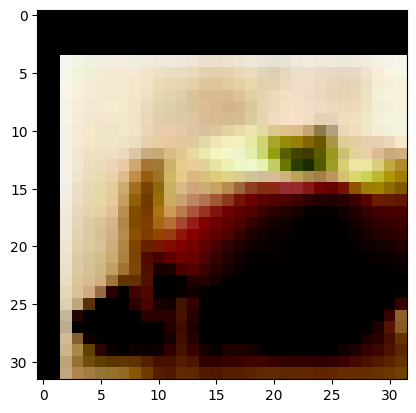

In [173]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [174]:
batch_size = 32
## apply the dataloader
torch.manual_seed(1311)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

torch.Size([32, 3, 32, 32])


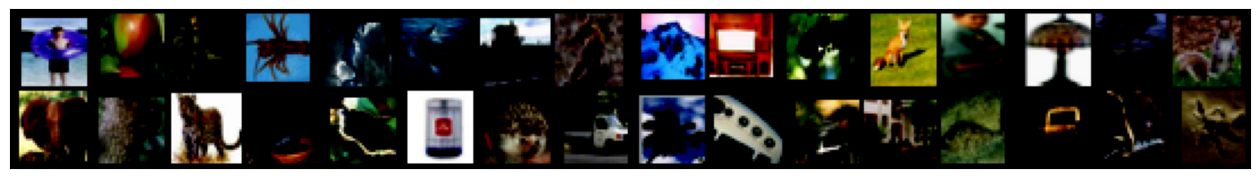

In [175]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [176]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311, num_class = num_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  # class_correct = list(0. for i in range(num_class))
                  # class_total = list(0. for i in range(num_class))
                  c = (preds == labels).squeeze()
                  for i in range(labels.size(0)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(num_class):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [177]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=num_class):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if num_class == 10:
          self.fc1 = nn.Linear(16 * 5 * 5, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, num_class)
        else:
          self.fc1 = nn.Linear(16 * 5 * 5, 200)
          self.fc2 = nn.Linear(200, 120)
          self.fc3 = nn.Linear(120, num_class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=100, bias=True)
)


### network: SimpleCNN

In [178]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [179]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [180]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [181]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

In [182]:
# set the whole network training
import torch.optim as optim
num_epochs = 15
criterion = nn.CrossEntropyLoss()

### Train the network - net

In [183]:
# # individual configuration
# net = Net().to(device)
# model = net
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# # training model
# net_results = train_network(model,
#                             optimizer,
#                             criterion,
#                             trainloader,
#                             testloader,
#                             num_epochs
#                             )

# # plot the chart
# plot_loss(net_results[0], net_results[2])
# plot_acc(net_results[1], net_results[3])

# # save the model info
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)


### Train the network - simpleCNN

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 112.30it/s]


Epoch 1/15, Train Loss: 3.7883, Train Acc: 11.75%, Test Loss: 3.3059, Test Acc: 19.84%, Time: 27.92s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.85it/s]


Epoch 2/15, Train Loss: 3.1921, Train Acc: 21.48%, Test Loss: 2.9475, Test Acc: 26.73%, Time: 28.09s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.97it/s]


Epoch 3/15, Train Loss: 2.9029, Train Acc: 27.30%, Test Loss: 2.6903, Test Acc: 32.05%, Time: 27.86s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.02it/s]


Epoch 4/15, Train Loss: 2.7204, Train Acc: 31.08%, Test Loss: 2.5806, Test Acc: 34.88%, Time: 27.84s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.49it/s]


Epoch 5/15, Train Loss: 2.5563, Train Acc: 34.57%, Test Loss: 2.4411, Test Acc: 37.62%, Time: 27.89s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.59it/s]


Epoch 6/15, Train Loss: 2.4238, Train Acc: 36.98%, Test Loss: 2.3255, Test Acc: 40.70%, Time: 27.93s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.58it/s]


Epoch 7/15, Train Loss: 2.3163, Train Acc: 39.58%, Test Loss: 2.2812, Test Acc: 40.99%, Time: 27.90s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 110.53it/s]


Epoch 8/15, Train Loss: 2.2155, Train Acc: 41.62%, Test Loss: 2.1905, Test Acc: 43.25%, Time: 27.96s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.59it/s]


Epoch 9/15, Train Loss: 2.1365, Train Acc: 43.36%, Test Loss: 2.1850, Test Acc: 43.53%, Time: 27.75s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 112.23it/s]


Epoch 10/15, Train Loss: 2.0609, Train Acc: 44.78%, Test Loss: 2.1004, Test Acc: 45.35%, Time: 27.99s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.07it/s]


Epoch 11/15, Train Loss: 1.9843, Train Acc: 46.69%, Test Loss: 2.0786, Test Acc: 45.79%, Time: 28.01s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.18it/s]


Epoch 12/15, Train Loss: 1.9349, Train Acc: 48.07%, Test Loss: 2.0132, Test Acc: 47.94%, Time: 28.08s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 116.04it/s]


Epoch 13/15, Train Loss: 1.8763, Train Acc: 49.11%, Test Loss: 2.0286, Test Acc: 47.49%, Time: 27.98s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.72it/s]


Epoch 14/15, Train Loss: 1.8238, Train Acc: 50.25%, Test Loss: 1.9936, Test Acc: 48.22%, Time: 27.83s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 87.96it/s]


Epoch 15/15, Train Loss: 1.7834, Train Acc: 51.33%, Test Loss: 1.9585, Test Acc: 49.06%, Time: 28.74s
Accuracy for each class
Accuracy of apple : 75 %
Accuracy of aquarium_fish : 63 %
Accuracy of  baby : 36 %
Accuracy of  bear : 22 %
Accuracy of beaver : 31 %
Accuracy of   bed : 42 %
Accuracy of   bee : 57 %
Accuracy of beetle : 58 %
Accuracy of bicycle : 62 %
Accuracy of bottle : 70 %
Accuracy of  bowl : 42 %
Accuracy of   boy : 33 %
Accuracy of bridge : 53 %
Accuracy of   bus : 49 %
Accuracy of butterfly : 42 %
Accuracy of camel : 31 %
Accuracy of   can : 48 %
Accuracy of castle : 54 %
Accuracy of caterpillar : 57 %
Accuracy of cattle : 38 %
Accuracy of chair : 76 %
Accuracy of chimpanzee : 79 %
Accuracy of clock : 36 %
Accuracy of cloud : 72 %
Accuracy of cockroach : 66 %
Accuracy of couch : 28 %
Accuracy of  crab : 41 %
Accuracy of crocodile : 42 %
Accuracy of   cup : 62 %
Accuracy of dinosaur : 42 %
Accuracy of dolphin : 63 %
Accuracy of elephant : 51 %
Accuracy of flatfish : 37 %

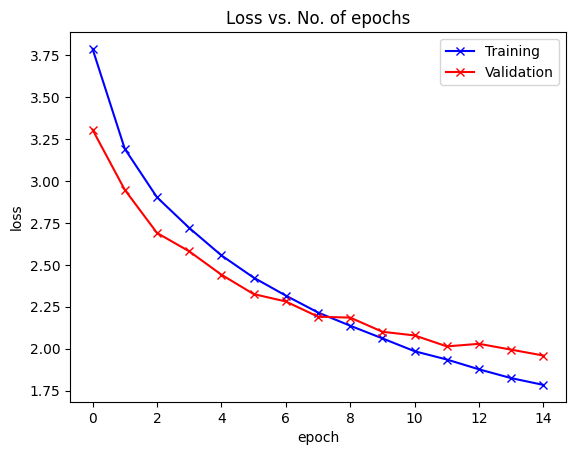

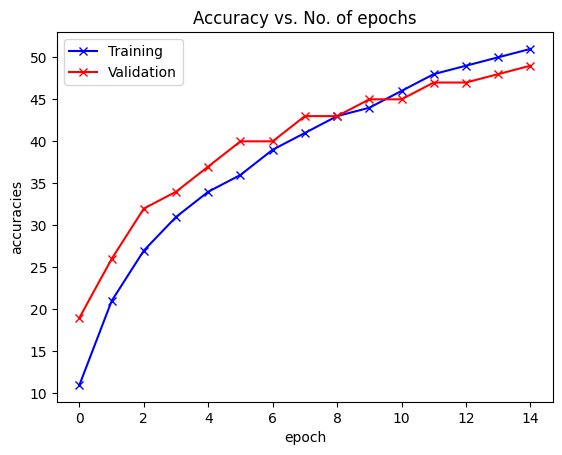

./cifar100_simplecnn.pth


In [184]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.16it/s]


Epoch 1/15, Train Loss: 4.1345, Train Acc: 5.29%, Test Loss: 3.7592, Test Acc: 10.31%, Time: 35.07s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.63it/s]


Epoch 2/15, Train Loss: 3.6438, Train Acc: 12.45%, Test Loss: 3.3377, Test Acc: 17.53%, Time: 34.91s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.78it/s]


Epoch 3/15, Train Loss: 3.3077, Train Acc: 18.80%, Test Loss: 3.0427, Test Acc: 23.58%, Time: 35.03s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.28it/s]


Epoch 4/15, Train Loss: 3.0516, Train Acc: 23.68%, Test Loss: 2.8079, Test Acc: 28.41%, Time: 35.19s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.09it/s]


Epoch 5/15, Train Loss: 2.8410, Train Acc: 28.04%, Test Loss: 2.6272, Test Acc: 32.57%, Time: 35.07s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.73it/s]


Epoch 6/15, Train Loss: 2.6726, Train Acc: 31.08%, Test Loss: 2.5315, Test Acc: 34.37%, Time: 35.13s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.31it/s]


Epoch 7/15, Train Loss: 2.5306, Train Acc: 34.05%, Test Loss: 2.3759, Test Acc: 37.66%, Time: 35.04s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.56it/s]


Epoch 8/15, Train Loss: 2.4209, Train Acc: 36.40%, Test Loss: 2.2920, Test Acc: 39.53%, Time: 35.05s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 108.19it/s]


Epoch 9/15, Train Loss: 2.3272, Train Acc: 38.21%, Test Loss: 2.2240, Test Acc: 41.47%, Time: 35.00s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.47it/s]


Epoch 10/15, Train Loss: 2.2444, Train Acc: 39.89%, Test Loss: 2.1229, Test Acc: 43.38%, Time: 35.07s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.12it/s]


Epoch 11/15, Train Loss: 2.1673, Train Acc: 41.30%, Test Loss: 2.0950, Test Acc: 44.40%, Time: 34.92s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.07it/s]


Epoch 12/15, Train Loss: 2.1058, Train Acc: 42.72%, Test Loss: 2.0591, Test Acc: 45.35%, Time: 34.91s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.81it/s]


Epoch 13/15, Train Loss: 2.0452, Train Acc: 44.41%, Test Loss: 2.0061, Test Acc: 46.53%, Time: 34.92s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.63it/s]


Epoch 14/15, Train Loss: 1.9856, Train Acc: 45.69%, Test Loss: 1.9635, Test Acc: 47.75%, Time: 34.96s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 84.57it/s]


Epoch 15/15, Train Loss: 1.9395, Train Acc: 46.86%, Test Loss: 1.9812, Test Acc: 47.01%, Time: 35.73s
Accuracy for each class
Accuracy of apple : 74 %
Accuracy of aquarium_fish : 63 %
Accuracy of  baby : 33 %
Accuracy of  bear : 28 %
Accuracy of beaver : 29 %
Accuracy of   bed : 48 %
Accuracy of   bee : 55 %
Accuracy of beetle : 47 %
Accuracy of bicycle : 46 %
Accuracy of bottle : 72 %
Accuracy of  bowl : 16 %
Accuracy of   boy : 29 %
Accuracy of bridge : 49 %
Accuracy of   bus : 36 %
Accuracy of butterfly : 44 %
Accuracy of camel : 40 %
Accuracy of   can : 41 %
Accuracy of castle : 58 %
Accuracy of caterpillar : 49 %
Accuracy of cattle : 39 %
Accuracy of chair : 75 %
Accuracy of chimpanzee : 84 %
Accuracy of clock : 35 %
Accuracy of cloud : 65 %
Accuracy of cockroach : 76 %
Accuracy of couch : 24 %
Accuracy of  crab : 39 %
Accuracy of crocodile : 44 %
Accuracy of   cup : 61 %
Accuracy of dinosaur : 30 %
Accuracy of dolphin : 70 %
Accuracy of elephant : 35 %
Accuracy of flatfish : 40 %

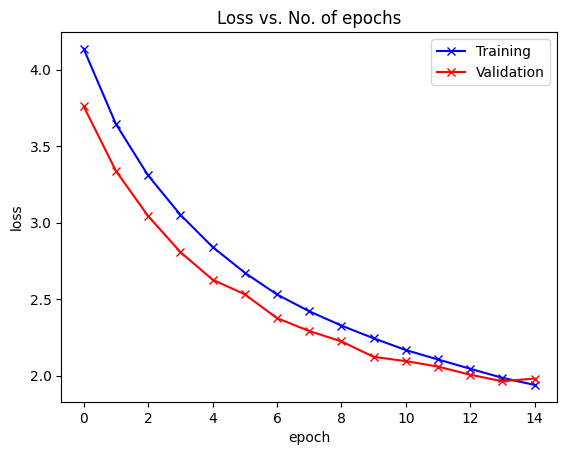

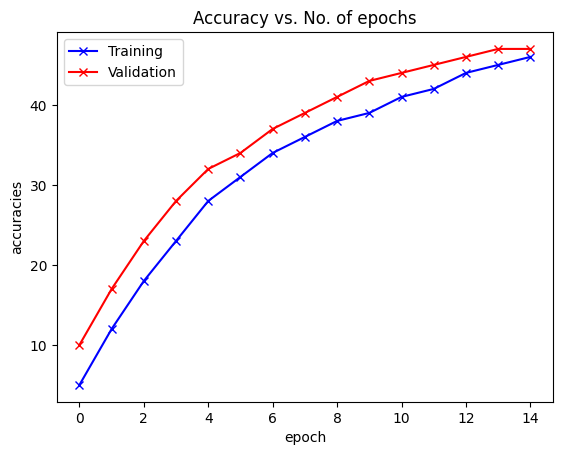

./cifar100_alexnet.pth


In [185]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(alexnet.state_dict(), PATH)

### Train the network - Resnet18

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.29it/s]


Epoch 1/15, Train Loss: 3.6520, Train Acc: 13.85%, Test Loss: 3.3204, Test Acc: 20.03%, Time: 40.47s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.40it/s]


Epoch 2/15, Train Loss: 2.7979, Train Acc: 28.46%, Test Loss: 2.5619, Test Acc: 34.15%, Time: 40.12s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.41it/s]


Epoch 3/15, Train Loss: 2.2816, Train Acc: 39.06%, Test Loss: 2.0551, Test Acc: 44.54%, Time: 40.24s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.73it/s]


Epoch 4/15, Train Loss: 1.9579, Train Acc: 46.39%, Test Loss: 1.8168, Test Acc: 50.10%, Time: 40.47s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.33it/s]


Epoch 5/15, Train Loss: 1.7375, Train Acc: 51.58%, Test Loss: 1.6881, Test Acc: 53.35%, Time: 40.36s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.53it/s]


Epoch 6/15, Train Loss: 1.5687, Train Acc: 56.06%, Test Loss: 1.5534, Test Acc: 56.02%, Time: 40.18s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.00it/s]


Epoch 7/15, Train Loss: 1.4248, Train Acc: 59.28%, Test Loss: 1.5195, Test Acc: 58.03%, Time: 40.31s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.13it/s]


Epoch 8/15, Train Loss: 1.3090, Train Acc: 62.22%, Test Loss: 1.4202, Test Acc: 59.55%, Time: 40.27s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.25it/s]


Epoch 9/15, Train Loss: 1.2090, Train Acc: 64.62%, Test Loss: 1.3834, Test Acc: 61.59%, Time: 40.44s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.35it/s]


Epoch 10/15, Train Loss: 1.1121, Train Acc: 67.16%, Test Loss: 1.3628, Test Acc: 62.68%, Time: 40.22s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.85it/s]


Epoch 11/15, Train Loss: 1.0323, Train Acc: 69.27%, Test Loss: 1.2996, Test Acc: 63.73%, Time: 40.44s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.83it/s]


Epoch 12/15, Train Loss: 0.9599, Train Acc: 71.35%, Test Loss: 1.2559, Test Acc: 65.38%, Time: 40.38s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.91it/s]


Epoch 13/15, Train Loss: 0.8857, Train Acc: 73.11%, Test Loss: 1.2303, Test Acc: 66.44%, Time: 40.45s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.93it/s]


Epoch 14/15, Train Loss: 0.8193, Train Acc: 74.97%, Test Loss: 1.2712, Test Acc: 65.90%, Time: 40.55s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 75.97it/s]


Epoch 15/15, Train Loss: 0.7668, Train Acc: 76.50%, Test Loss: 1.2459, Test Acc: 66.45%, Time: 41.04s
Accuracy for each class
Accuracy of apple : 76 %
Accuracy of aquarium_fish : 88 %
Accuracy of  baby : 37 %
Accuracy of  bear : 40 %
Accuracy of beaver : 62 %
Accuracy of   bed : 67 %
Accuracy of   bee : 66 %
Accuracy of beetle : 65 %
Accuracy of bicycle : 92 %
Accuracy of bottle : 82 %
Accuracy of  bowl : 69 %
Accuracy of   boy : 43 %
Accuracy of bridge : 77 %
Accuracy of   bus : 56 %
Accuracy of butterfly : 61 %
Accuracy of camel : 75 %
Accuracy of   can : 62 %
Accuracy of castle : 85 %
Accuracy of caterpillar : 66 %
Accuracy of cattle : 53 %
Accuracy of chair : 85 %
Accuracy of chimpanzee : 83 %
Accuracy of clock : 56 %
Accuracy of cloud : 92 %
Accuracy of cockroach : 81 %
Accuracy of couch : 59 %
Accuracy of  crab : 66 %
Accuracy of crocodile : 54 %
Accuracy of   cup : 80 %
Accuracy of dinosaur : 67 %
Accuracy of dolphin : 78 %
Accuracy of elephant : 73 %
Accuracy of flatfish : 69 %

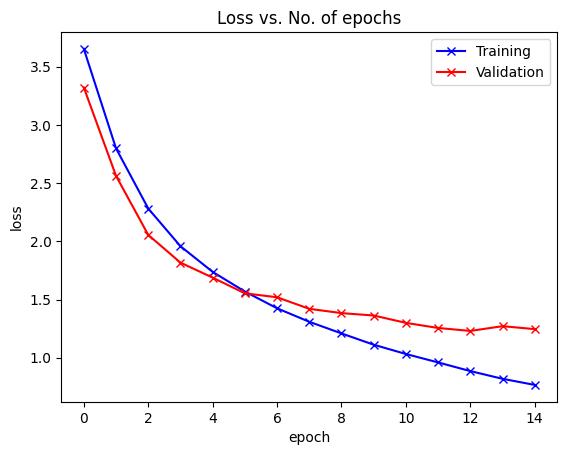

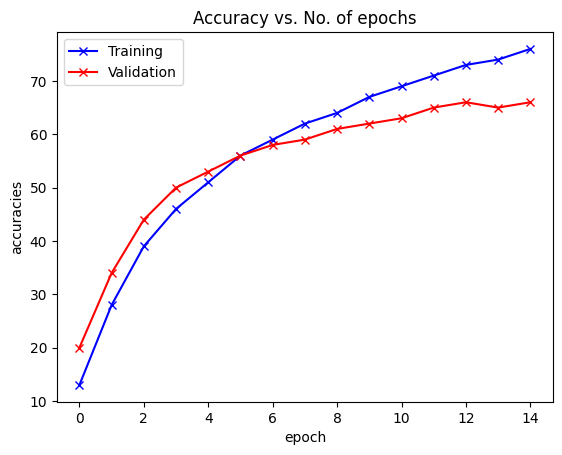

./cifar100_resnet18.pth


In [186]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet18.state_dict(), PATH)

### Train the network - Resnet34

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 75.55it/s]


Epoch 1/15, Train Loss: 3.8493, Train Acc: 10.63%, Test Loss: 3.4167, Test Acc: 17.44%, Time: 53.08s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.81it/s]


Epoch 2/15, Train Loss: 3.0795, Train Acc: 23.04%, Test Loss: 2.6667, Test Acc: 31.55%, Time: 53.29s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 75.83it/s]


Epoch 3/15, Train Loss: 2.5246, Train Acc: 33.79%, Test Loss: 2.2229, Test Acc: 39.76%, Time: 52.92s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.24it/s]


Epoch 4/15, Train Loss: 2.1528, Train Acc: 41.83%, Test Loss: 1.9115, Test Acc: 47.59%, Time: 53.07s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.10it/s]


Epoch 5/15, Train Loss: 1.8890, Train Acc: 47.74%, Test Loss: 1.7528, Test Acc: 51.32%, Time: 52.95s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.02it/s]


Epoch 6/15, Train Loss: 1.7008, Train Acc: 52.52%, Test Loss: 1.6017, Test Acc: 55.08%, Time: 53.27s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.37it/s]


Epoch 7/15, Train Loss: 1.5397, Train Acc: 56.09%, Test Loss: 1.5580, Test Acc: 56.09%, Time: 52.92s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.48it/s]


Epoch 8/15, Train Loss: 1.4133, Train Acc: 59.29%, Test Loss: 1.4854, Test Acc: 58.12%, Time: 53.10s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.10it/s]


Epoch 9/15, Train Loss: 1.2930, Train Acc: 62.59%, Test Loss: 1.4303, Test Acc: 60.00%, Time: 53.05s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.81it/s]


Epoch 10/15, Train Loss: 1.1958, Train Acc: 65.00%, Test Loss: 1.4080, Test Acc: 61.12%, Time: 52.69s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.71it/s]


Epoch 11/15, Train Loss: 1.1048, Train Acc: 67.40%, Test Loss: 1.3702, Test Acc: 62.21%, Time: 52.93s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.67it/s]


Epoch 12/15, Train Loss: 1.0269, Train Acc: 69.26%, Test Loss: 1.3067, Test Acc: 63.94%, Time: 53.28s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.28it/s]


Epoch 13/15, Train Loss: 0.9503, Train Acc: 71.42%, Test Loss: 1.2656, Test Acc: 65.66%, Time: 52.89s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.04it/s]


Epoch 14/15, Train Loss: 0.8787, Train Acc: 73.36%, Test Loss: 1.3114, Test Acc: 64.75%, Time: 53.02s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.31it/s]


Epoch 15/15, Train Loss: 0.8147, Train Acc: 74.99%, Test Loss: 1.2615, Test Acc: 66.20%, Time: 53.69s
Accuracy for each class
Accuracy of apple : 75 %
Accuracy of aquarium_fish : 79 %
Accuracy of  baby : 48 %
Accuracy of  bear : 51 %
Accuracy of beaver : 68 %
Accuracy of   bed : 68 %
Accuracy of   bee : 78 %
Accuracy of beetle : 59 %
Accuracy of bicycle : 80 %
Accuracy of bottle : 85 %
Accuracy of  bowl : 68 %
Accuracy of   boy : 44 %
Accuracy of bridge : 75 %
Accuracy of   bus : 62 %
Accuracy of butterfly : 56 %
Accuracy of camel : 75 %
Accuracy of   can : 56 %
Accuracy of castle : 82 %
Accuracy of caterpillar : 75 %
Accuracy of cattle : 58 %
Accuracy of chair : 85 %
Accuracy of chimpanzee : 79 %
Accuracy of clock : 61 %
Accuracy of cloud : 89 %
Accuracy of cockroach : 83 %
Accuracy of couch : 46 %
Accuracy of  crab : 73 %
Accuracy of crocodile : 56 %
Accuracy of   cup : 73 %
Accuracy of dinosaur : 66 %
Accuracy of dolphin : 82 %
Accuracy of elephant : 68 %
Accuracy of flatfish : 71 %

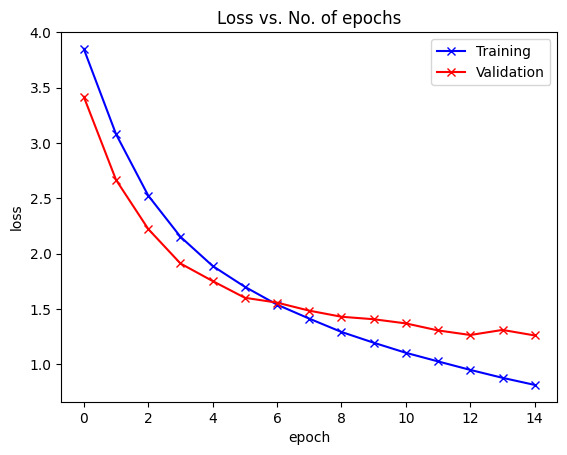

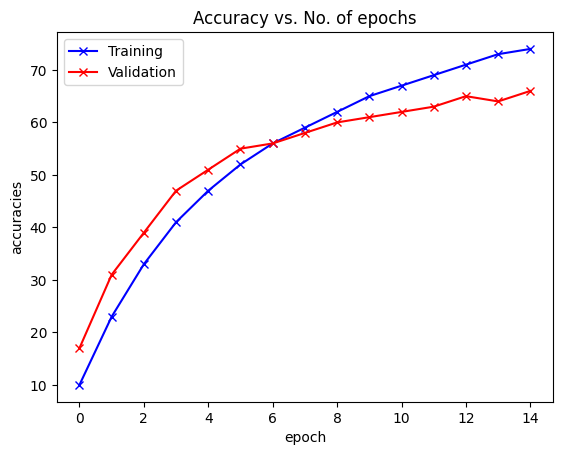

./cifar100_resnet34.pth


In [187]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet34.state_dict(), PATH)

### Train the network - Resnet50

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.99it/s]


Epoch 1/15, Train Loss: 3.9258, Train Acc: 9.47%, Test Loss: 3.4739, Test Acc: 17.33%, Time: 64.47s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.92it/s]


Epoch 2/15, Train Loss: 3.0906, Train Acc: 22.90%, Test Loss: 3.0566, Test Acc: 28.63%, Time: 64.52s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.47it/s]


Epoch 3/15, Train Loss: 2.5185, Train Acc: 33.65%, Test Loss: 2.5682, Test Acc: 38.57%, Time: 64.26s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.04it/s]


Epoch 4/15, Train Loss: 2.1898, Train Acc: 41.16%, Test Loss: 2.6078, Test Acc: 44.77%, Time: 64.34s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.61it/s]


Epoch 5/15, Train Loss: 1.9184, Train Acc: 47.20%, Test Loss: 1.9292, Test Acc: 51.18%, Time: 64.05s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.25it/s]


Epoch 6/15, Train Loss: 1.7272, Train Acc: 52.07%, Test Loss: 2.1032, Test Acc: 50.97%, Time: 64.08s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.80it/s]


Epoch 7/15, Train Loss: 1.5896, Train Acc: 55.26%, Test Loss: 1.7416, Test Acc: 54.82%, Time: 64.36s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.75it/s]


Epoch 8/15, Train Loss: 1.4397, Train Acc: 59.06%, Test Loss: 1.5385, Test Acc: 57.76%, Time: 64.32s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.06it/s]


Epoch 9/15, Train Loss: 1.3277, Train Acc: 61.67%, Test Loss: 1.6163, Test Acc: 59.30%, Time: 63.93s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.00it/s]


Epoch 10/15, Train Loss: 1.2271, Train Acc: 64.26%, Test Loss: 1.9588, Test Acc: 59.35%, Time: 64.92s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.20it/s]


Epoch 11/15, Train Loss: 1.1398, Train Acc: 66.37%, Test Loss: 1.4364, Test Acc: 61.89%, Time: 65.14s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.57it/s]


Epoch 12/15, Train Loss: 1.0605, Train Acc: 68.51%, Test Loss: 1.3653, Test Acc: 64.23%, Time: 65.48s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.31it/s]


Epoch 13/15, Train Loss: 0.9934, Train Acc: 70.32%, Test Loss: 1.4428, Test Acc: 65.17%, Time: 65.80s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.59it/s]


Epoch 14/15, Train Loss: 0.9178, Train Acc: 72.46%, Test Loss: 1.3453, Test Acc: 64.39%, Time: 65.15s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.66it/s]


Epoch 15/15, Train Loss: 0.8589, Train Acc: 73.80%, Test Loss: 1.3575, Test Acc: 65.95%, Time: 66.23s
Accuracy for each class
Accuracy of apple : 48 %
Accuracy of aquarium_fish : 77 %
Accuracy of  baby : 52 %
Accuracy of  bear : 46 %
Accuracy of beaver : 60 %
Accuracy of   bed : 67 %
Accuracy of   bee : 73 %
Accuracy of beetle : 62 %
Accuracy of bicycle : 85 %
Accuracy of bottle : 77 %
Accuracy of  bowl : 56 %
Accuracy of   boy : 65 %
Accuracy of bridge : 82 %
Accuracy of   bus : 59 %
Accuracy of butterfly : 53 %
Accuracy of camel : 76 %
Accuracy of   can : 67 %
Accuracy of castle : 75 %
Accuracy of caterpillar : 76 %
Accuracy of cattle : 57 %
Accuracy of chair : 80 %
Accuracy of chimpanzee : 92 %
Accuracy of clock : 56 %
Accuracy of cloud : 81 %
Accuracy of cockroach : 82 %
Accuracy of couch : 54 %
Accuracy of  crab : 57 %
Accuracy of crocodile : 56 %
Accuracy of   cup : 62 %
Accuracy of dinosaur : 72 %
Accuracy of dolphin : 77 %
Accuracy of elephant : 73 %
Accuracy of flatfish : 68 %

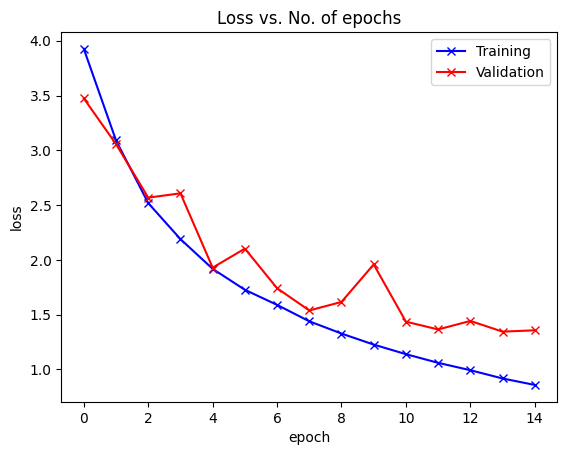

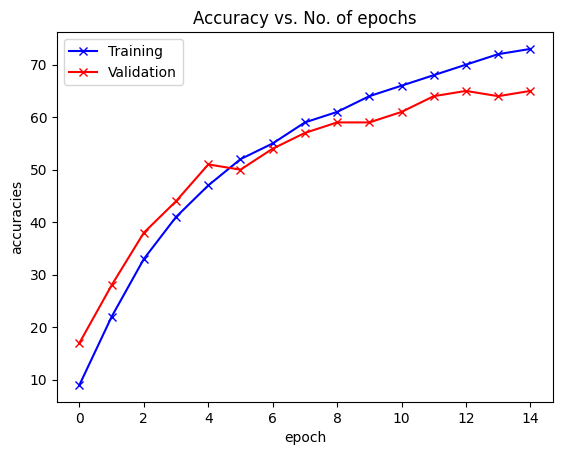

./cifar100_resnet50.pth


In [188]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet50_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet50_results[0], resnet50_results[2])
plot_acc(resnet50_results[1], resnet50_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet50.state_dict(), PATH)

## Load the Model

In [189]:
# net = Net()
# net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load(f'./{dataset}_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load(f'./{dataset}_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load(f'./{dataset}_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load(f'./{dataset}_resnet34.pth'))

resnet50 = ResNet50()
resnet50.load_state_dict(torch.load(f'./{dataset}_resnet50.pth', map_location=device))

<All keys matched successfully>